<a href="https://colab.research.google.com/github/pmap1986/Paula_Alfonso_KC/blob/main/Caso_Accidentes_NYC_Paula_Alfonso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ¿Cómo podemos controlar el creciente número de accidentes en Nueva York?

In [2]:
import json
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Introduccion

**Contexto empresarial.** La ciudad de Nueva York ha experimentado un aumento en el número de accidentes en las carreteras de la ciudad. Quieren saber si el número de accidentes ha aumentado en las últimas semanas. Para todos los accidentes reportados, han recopilado detalles para cada accidente y han estado manteniendo registros durante el último año y medio (desde enero de 2018 hasta agosto de 2019).

La ciudad te ha contratado para que construyas visualizaciones que les ayuden a identificar patrones en accidentes, lo que les ayudaría a tomar acciones preventivas para reducir la cantidad de accidentes en el futuro. Tienen ciertos parámetros como municipio, hora del día, motivo del accidente, etc. De los que se preocupan y de los que les gustaría obtener información específica.

**Problema comercial.** Su tarea es formatear los datos proporcionados y proporcionar visualizaciones que respondan las preguntas específicas que tiene el cliente, que se mencionan a continuación.

**Contexto analítico.** Se le proporciona un archivo CSV (almacenado en la carpeta ```datos``` ya creada) que contiene detalles sobre cada accidente, como fecha, hora, ubicación del accidente, motivo del accidente, tipos de vehículos involucrados, recuento de lesiones y muertes, etc. El delimitador en el archivo CSV dado es `;` en lugar del predeterminado `,`. Realizará las siguientes tareas con los datos:

1. Extraiga datos adicionales del municipio almacenados en un archivo JSON
2. Leer, transformar y preparar datos para su visualización
3. Realizar análisis y construir visualizaciones de los datos para identificar patrones en el conjunto de datos.
        
El cliente tiene un conjunto específico de preguntas a las que le gustaría obtener respuestas. Deberá proporcionar visualizaciones para acompañar estos:

1. ¿Cómo ha fluctuado el número de accidentes durante el último año y medio? ¿Han aumentado con el tiempo?
2. Para un día en particular, ¿durante qué horas es más probable que ocurran accidentes?
3. ¿Hay más accidentes entre semana que durante los fines de semana?
4. ¿Cuál es la proporción de recuento de accidentes por área por municipio? ¿Qué distritos tienen un número desproporcionadamente grande de accidentes para su tamaño?
5. Para cada municipio, ¿durante qué horas es más probable que ocurran accidentes?
6. ¿Cuáles son las 5 principales causas de accidentes en la ciudad?
7. ¿Qué tipos de vehículos están más involucrados en accidentes por municipio?
8. ¿Qué tipos de vehículos están más involucrados en las muertes?

## Obteniendo los datos relevantes

El cliente ha solicitado un análisis de la relación accidentes-área de los distritos. Los datos del municipio se almacenan en un archivo JSON en la carpeta ```datos```.

### Pregunta 

Utilice la función ```json.load()``` para cargar el archivo ```borough_data.json``` como diccionario.

**Respuesta.** 

In [6]:
with open('/content/drive/MyDrive/Mujeres digitales sena/Taller4_Caso_real_NYC/Caso NYC/data/borough_data.json') as f:
    borough_data=json.load(f)
    
borough_data

{'brooklyn': {'area': 70.82, 'name': 'brooklyn', 'population': 2648771.0},
 'manhattan': {'area': 22.83, 'name': 'manhattan', 'population': 1664727.0},
 'queens': {'area': 108.53, 'name': 'queens', 'population': 2358582.0},
 'staten island': {'area': 58.37,
  'name': 'staten island',
  'population': 479458.0},
 'the bronx': {'area': 42.1, 'name': 'the bronx', 'population': 1471160.0}}

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Pregunta 
De manera similar, use la función pandas ```read_csv()``` para cargar el archivo ```accidentes.csv``` como un DataFrame. Nombra este DataFrame ```df```.


**Respuesta.** 

In [7]:
%cd '/content/drive/MyDrive/Mujeres digitales sena/Taller4_Caso_real_NYC/Caso NYC/data'

/content/drive/MyDrive/Mujeres digitales sena/Taller4_Caso_real_NYC/Caso NYC/data


In [8]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
with open('/content/drive/MyDrive/Mujeres digitales sena/Taller4_Caso_real_NYC/Caso NYC/data/accidents.csv') as f:
    df=pd.read_csv(f, delimiter=';')

In [4]:
df.head()

NameError: ignored

## Overview de la data

Analizemos las columnas presentes en el data frame

In [ ]:
df.columns

Index(['DATE', 'TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE',
       'ON STREET NAME', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5',
       'Month', 'hour'],
      dtype='object')

Tenemos las siguientes columnas

1. **BOROUGH**: el municipio en el que ocurrió el accidente
2. **COLLISION_ID**: un identificador único para esta colisión
3. **CONTRIBUTING FACTOR VEHICLE (1, 2, 3, 4, 5)**: Motivos del accidente
4. **CROSS STREET NAME**: Calle transversal más cercana al lugar del accidente
5. **DATE**: Fecha del accidente
6. **TIME**: Hora del accidente
7. **LATITUDE**: Latitud del accidente
8. **LONGITUDE**: Longitud del accidente
9. **NUMBER OF (CYCLISTS, MOTORISTS, PEDESTRIANS) INJURED**: Lesión por categoría
10. **NUMBER OF (CYCLISTS, MOTORISTS, PEDESTRIANS) DEATHS**: Categoría muerte sabia
11. **ON STREET NAME**: Calle donde ocurrió el accidente
13. **VEHICLE TYPE CODE(1, 2, 3, 4, 5)**: Tipos de vehículos involucrados en el accidente
14. **ZIP CODE**: código postal del lugar del accidente

### Ejercicio 1

Desde 2014, la ciudad de Nueva York ha estado implementando un plan de seguridad vial llamado [Vision Zero](https://www1.nyc.gov/content/visionzero/pages/). Su objetivo es reducir el número de muertes por accidentes de tránsito a *cero* para fines de 2024. El plan está creando nuevas y mejorando las medidas de seguridad actuales, algunas de ellas incluyen:

- [ ] Detección de peatones automatizada
- [ ] Auditorías de seguridad vial en lugares de alto riesgo
- [ ] Ampliación de la red de carriles bici
- [ ] Iniciativas específicas de educación y sensibilización
- [ ] Creación de islas de refugio peatonal
- [ ] Lanzamiento del programa integrado de reductor de velocidad basado en datos (topes y amortiguadores de velocidad)

¿Cuáles de estas iniciativas podrían beneficiarse directamente de un análisis de los datos proporcionados? Marque todo lo que corresponda.

**Nota:** Puede crear marcas de verificación haciendo doble clic en esta celda y agregando una ```[x]``` en las líneas correspondientes.

**Respuesta.**

- [ ] Detecciòn de peatones automatizada


- [X ] Auditorías de seguridadvial en lugares de alto riesgo

- [X ] Ampliación de la red de carriles bici

- [X ] Iniciativas especificas de educación y sensibilización

- [X ] Creación de islas de refugio peatonal

- [ ] Lanzamiento del programa integrado de reductor de velocidad en datos (topes y amortiguadores de velocidad)


Sigamos adelante y respondamos a cada una de las preguntas del cliente.

## Respondiendo las preguntas del cliente 

### Ejercicio 2 

Agrupe los datos disponibles mensualmente y genere un line plot de accidentes a lo largo del tiempo. ¿Ha aumentado el número de accidentes durante el último año y medio?

**Sugerencia**: Puede encontrar útiles las funciones de pandas ```to_datetime ()``` y ```dt.to_period ()```.

**Respuesta.** 

In [12]:
df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')

In [13]:
df['Month'] = df['DATE'].dt.to_period('M')

In [14]:
ACC_MES = df.groupby(df['DATE'].dt.to_period('M')).size()
ACC_MES

DATE
2018-01    11735
2018-02    10395
2018-03    12519
2018-04    11679
2018-05    13438
2018-06    13314
2018-07    12787
2018-08    12644
2018-09    12425
2018-10    13336
2018-11    12447
2018-12    12479
2019-01    11000
2019-02    10310
2019-03    11482
2019-04    10833
2019-05    12642
2019-06    12577
2019-07    12014
2019-08     8466
Freq: M, dtype: int64

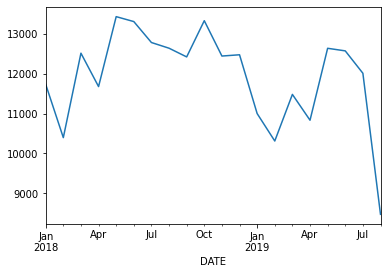

In [15]:
ACC_MES.plot.line()


> en los meses de diciembre a febrero a disminuido en gran medida, esto es debido, a que corresponde con la epoca de invierno. Por lo anterior, en febrero aumentan el numero de accidentes.

Comparando mayo de 2018 con mayo de 2019, en 2018 hubo mayor cantidad de accidentes.



### Ejercicio 3

De la gráfica anterior, ¿qué meses parecen tener el menor número de accidentes? ¿Cuáles crees que son las razones detrás de esto?

**Respuesta.** 


de enero a febrero de 2018 disminuyen los accidentes por la epoca de invierno. Así como de diciembre a febrero en 2019.

In [16]:
df['hour'] = pd.to_datetime(df['TIME'], errors='coerce')
df['hour'] = df['hour'].dt.hour


### Ejercicio 4 
¿Cómo varía el número de accidentes a lo largo de un solo día? Cree una nueva columna `HOUR` basada en los datos de la columna `TIME`, luego trace un gráfico de barras de la distribución por hora a lo largo del día.

**Sugerencia:** Puede encontrar útil la función ```dt.hour```.

**Respuesta.**

In [18]:
df['DIA'] = df['DATE'].dt.to_period('D')
ACC_DIARIO = df.groupby(df['hour']).size()



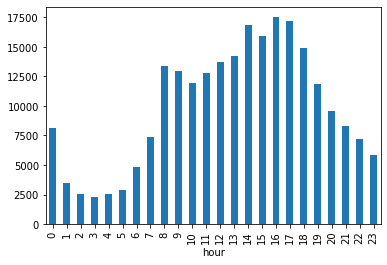

In [ ]:
ACC_DIARIO.plot.bar()




> Se puede observar que a lo largo del dia, desde las 6 am va aumentando el numero de accidentes siendo mayor a las 8 am, pero va aumentando mas desde las 10 am, siendo mayor a las 4pm y va disminuyendo a las 5pm. Esto puede concordar con las horas pico. 



### Ejercicio 5 

En la pregunta anterior hemos agregado el número de accidentes por hora sin tener en cuenta la fecha y el lugar en que ocurrieron. ¿Qué crítica le daría a este enfoque?

**Respuesta.** 


> Nos ayuda a determinar en que horas del dia es mas frecuente los accidentes. En este caso, segun la grafica, son mas frecuentes en las horas de la tarde, entre las 2 y 5 pm.



### Ejercicio 6 

¿Cómo varía el número de accidentes en una sola semana? Trace un gráfico de barras basado en el recuento de accidentes por día de la semana.

**Sugerencia:** Puede encontrar útil la función ```dt.weekday```.

**Respuesta.**

In [24]:
dayOfWeek={0:'Lun', 1:'Mar', 2:'Mie', 3:'Jue', 4:'Vie', 5:'Sab', 6:'Dom'}
df['SEMANA'] = df['DATE'].dt.weekday
df['DIA'] = df['DATE'].dt.weekday.map(dayOfWeek)

ACC_SEM = df.groupby([df['DIA'], df['SEMANA']]).size()


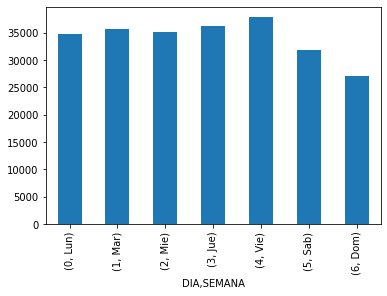

In [ ]:
ACC_SEM.plot.bar()

La mayor cantidad de accidentes sucede entre semana, siendo en mayor cantidad los viernes(4), disminuye la cantidad de accidentes los fines de semana en mayor medida los domingos (6).

### Ejercicio 7

Trace una gráfica de barras del número total de accidentes en cada municipio, así como uno de los accidentes por milla cuadrada por municipio. ¿Qué puedes concluir?

**Sugerencia:** Es posible que desee actualizar algunas de las claves en el diccionario del municipio para que coincidan con los nombres en el marco de datos.

**Respuesta.**

In [25]:
ACC_MUNIC = df.groupby(df['BOROUGH']).size()

In [27]:
valores = borough_data.values()

In [28]:
areas_b={}
for i in valores:
  areas = i['area'] 
  names = i['name']
  areas_b[names]=areas
print(areas_b) 

{'the bronx': 42.1, 'brooklyn': 70.82, 'manhattan': 22.83, 'queens': 108.53, 'staten island': 58.37}


Text(0.5, 1.0, 'Area por Municipio')

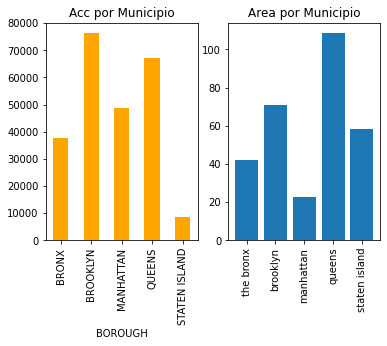

In [29]:
import matplotlib.pyplot as plt
plt.subplot(121)
ACC_MUNIC.plot.bar(color='orange')
plt.title('Acc por Municipio')
plt.subplot(122)
plt.bar(range(len(areas_b)), areas_b.values(), align= 'center')
plt.xticks(range(len(areas_b)), list(areas_b.keys()), rotation=90)
plt.title('Area por Municipio')



> BROOKLYN tiene menos area que Queens pero tiene mayor cantidad de accidentes.
Así como MANHATTAN tiene la mitad del area de THE BRONX pero lo supera en numero de accidentes.
STATEN ISLAND tiene un area promedio y es la que tiene menor cantidad de accidentes.



### Ejercicio 8 

¿Qué horas tienen más accidentes en cada municipio? Trace un gráfico de barras para cada municipio que muestre el número de accidentes por cada hora del día.

**Sugerencia:** Puede usar ```sns.FacetGrid``` para crear una cuadrícula de parcelas con los datos por hora de cada municipio.

**Respuesta.**

In [35]:
munic_hor = pd.DataFrame({'accidentes' : df.groupby( [ "BOROUGH", "hour"] ).size()}).reset_index()

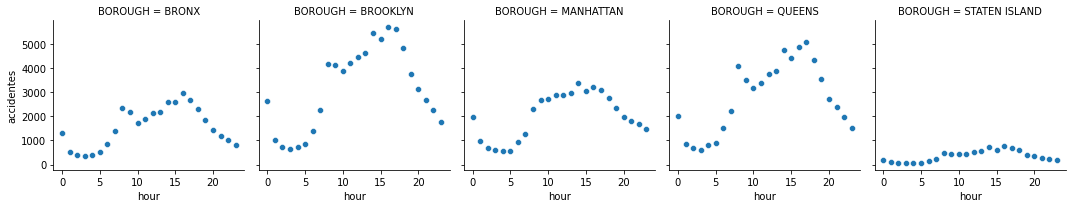

In [36]:
g = sns.FacetGrid(munic_hor, col='BOROUGH')
g.map(sns.scatterplot, 'hour', 'accidentes')

**¿Es mayor el número de accidentes en diferentes momentos en diferentes distritos? ¿Deberíamos concentrarnos en diferentes momentos para cada municipio?**


> En todos los distritos coinciden en que el mayor numero de accidentes pasa alrededor de las 16:00 horas, es decir alrededor de las 4 pm.



### Ejercicio 9 

¿Qué factores provocan la mayoría de los accidentes? Evite contar dos veces los factores que contribuyen a un solo accidente.

**Sugerencia:** Una forma de lidiar con las repeticiones es concatenar las columnas correspondientes conservando sus índices, puede hacerlo con las funciones ```pd.concat()``` y ```reset_index()```. Luego, use un ```group_by``` apropiado para contar el número de repeticiones de factores contribuidos por accidente.

**Respuesta**.


> los factores que provocan la mayoria de accidentes son: inespecifico, distraccion del conductor y no ceder el paso.




In [160]:
fact_acc = pd.DataFrame({'factores': pd.concat([df['CONTRIBUTING FACTOR VEHICLE 1'],df['CONTRIBUTING FACTOR VEHICLE 2'],df['CONTRIBUTING FACTOR VEHICLE 3'],df['CONTRIBUTING FACTOR VEHICLE 4'],df['CONTRIBUTING FACTOR VEHICLE 5']], sort = False)}).reset_index()

fact_accidentes = fact_acc.groupby(['factores']).size()


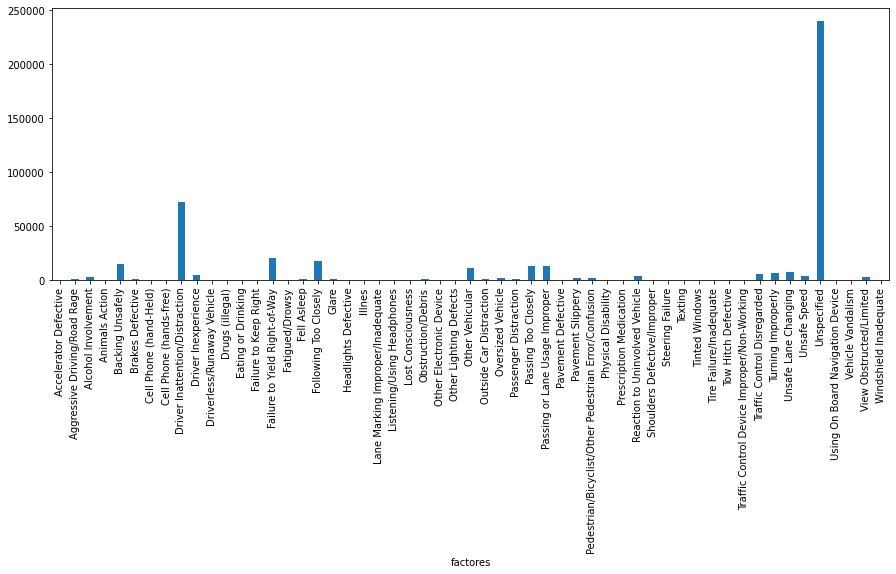

In [159]:
fact_accidentes.plot.bar(figsize=(15,5))
#plt.figure(figsize=(100,100))

In [81]:
#df.groupby(['CONTRIBUTING FACTOR VEHICLE 1']).size()

### Ejercicio 10 

¿Qué tipos de vehículos están más involucrados en accidentes por municipio? Evite contar dos veces el tipo de vehículos presentes en un solo accidente.

**Sugerencia:** Puede aplicar un enfoque similar al utilizado en la pregunta anterior.

**Respuesta.** 

In [3]:
vehic_acc = pd.DataFrame({'Vehiculos' : pd.concat([df['VEHICLE TYPE CODE 1'],df['VEHICLE TYPE CODE 2'],df['VEHICLE TYPE CODE 3'],df['VEHICLE TYPE CODE 4'],df['VEHICLE TYPE CODE 5']],sort= False)}).reset_index()
va = vehic_acc.groupby(['Vehiculos']).size()
va

NameError: ignored

### Ejercicio 11 

En 2018 para una [entrevista](https://www.nytimes.com/2019/01/01/nyregion/traffic-deaths-decrease-nyc.html) con The New York Times, el alcalde de Blasio de Nueva York declaró que *'Vision Zero está funcionando claramente'*. Ese año, el número de muertes en accidentes de tráfico en Nueva York se redujo a un histórico 202. Sin embargo, según lo informado por [am New York Metro](https://www.amny.com/news/vision-zero-de-blasio- 1-30707464 /), el número de víctimas mortales ha aumentado un 30% en el primer trimestre de 2019 en comparación con el año anterior y el número de peatones y ciclistas heridos no ha experimentado ninguna mejora.

¿Cómo utilizaría los datos proporcionados para comprender qué salió mal en el primer trimestre de 2019?


> - [ ] Considere los accidentes del primer trimestre de 2019. Luego, busque las causas más comunes de accidentes en los que estuvieron involucrados peatones y ciclistas. Dé una recomendación basada únicamente en esta información.

> - [ ] Cree un par de mapas de calor de los accidentes que involucraron a peatones y ciclistas lesionados / muertos en el primer trimestre de 2018 y 2019. Compare estos dos para ver si hay algún cambio en la concentración de accidentes. En áreas críticas, estudie el tipo de factores involucrados en los accidentes. Dé una recomendación para visitar estas áreas para estudiar más el problema.   

> - [ ] Los datos proporcionados son insuficientes para mejorar nuestra comprensión de la situación.

> - [ ] Ninguna de las anteriores. Haría lo siguiente: *aquí tu respuesta recomendada*.

**Respuesta.**


### Ejercicio 12 

Calcula el número de muertes provocadas por cada tipo de vehículo. Trace un gráfico de barras para los 5 vehículos principales. ¿Qué vehículos están involucrados con mayor frecuencia en las muertes y cuánto más que los demás?

**Por ejemplo,** si dos personas murieron en un accidente en el que estuvieron involucrados 5 vehículos: 4 son VEHÍCULOS DE PASAJEROS y 1 es un VAGÓN DEPORTIVO / ESTACIÓN. Luego, agregaríamos dos muertes a cada tipo de VEHÍCULO DE PASAJEROS y VAGÓN DE ESTACIÓN / SERVICIO DEPORTIVO.

**Sugerencia:** Es posible que desee crear una nueva columna con el número total de muertes en el accidente. Para eso, puede encontrar útil la función ```.to_numpy()```. Luego, proceda como los ejercicios anteriores para evitar contabilizar dos veces el tipo de vehículos.

**Repsuesta.**